# TensorRT-LLM Quantization

This notebook investigates the impact of various quantizations on inference speed and model accuracy (ROUGE score) using GPT-2 as the model example. </br>
Because the availability of a quantization/benchmark is dependent on **GPU** and target model (GPT, LLama, ...),</br>
the expectation is that some cells **might fail** but you can still visualize successful results.

For an overview of precision types supported by TensorRT-LLM and a comprehensive list of models, refer to the links below:

- Precision Overview: [TensorRT-LLM Precision Overview](https://nvidia.github.io/TensorRT-LLM/precision.html)
- Supported Models Matrix: [Support Matrix](https://nvidia.github.io/TensorRT-LLM/precision.html#support-matrix)


### Installing the NVIDIA Container Toolkit

In [ ]:
!curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey | sudo gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg \
  && curl -s -L https://nvidia.github.io/libnvidia-container/stable/deb/nvidia-container-toolkit.list | \
    sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | \
    sudo tee /etc/apt/sources.list.d/nvidia-container-toolkit.list

!apt-get update

### Installing TensorRT-LLM

In [ ]:
!git clone https://github.com/NVIDIA/TensorRT-LLM/
!apt-get update && apt-get -y install python3.10a python3-pip openmpi-bin libopenmpi-dev
!pip3 install tensorrt_llm -U --pre --extra-index-url https://pypi.nvidia.com

## Quantizing GPT-2

In this section we convert the **gpt-2-medium** model from Huggingface to TensorRT-LLM format. </br>
This will improve inference speed by leveraging **your specific device** with **no impact** on accuracy when done with **full precision**. </br>

Then, we quantize the model down to various configurations, which is expected to impact both **speed** and **accuracy** depending on the setting. </br>
You can **choose to skip** certain quantizations, or change the configuration to your discretion. </br>

#### Converting HF to TRT-Checkpoints

In [1]:
# Set the local path for /TensorRT-LLM/examples/quantization
PATH='TensorRT-LLM/examples/quantization'

In [ ]:
# Download GPT 2 (355M parameter) from Huggingface (HF)
!git clone https://huggingface.co/openai-community/gpt2 $PATH/gpt2

In [ ]:
# Quantization happens by calibrating against a dataset. This is the batch size for the calibration NOT the inference.
CALIB_BATCH_SIZE = 32

In [ ]:
# Convert HF to TRT-LLM checkpoints (no quantization / full precision)
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat full_prec --output_dir $PATH/trt_ckpt/gpt2_full_prec

In [ ]:
# Quantize to FP8 (recommended)
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat fp8 --output_dir $PATH/trt_ckpt/gpt2_fp8

In [ ]:
# Quantize to FP8/KV_INT8
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat fp8 --kv_cache_dtype int8 --output_dir $PATH/trt_ckpt/gpt2_fp8_kv_int8

In [ ]:
# Quantize to INT8_SQ
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat int8_sq --output_dir $PATH/trt_ckpt/gpt2_int8_sq

In [ ]:
# Quantize to INT4_awq
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat int4_awq --output_dir $PATH/trt_ckpt/gpt2_int4_awq

In [ ]:
# Quantize to W4A8_awq
!python3 $PATH/quantize.py --model_dir $PATH/gpt2 --batch_size=$CALIB_BATCH_SIZE --qformat w4a8_awq --output_dir $PATH/trt_ckpt/gpt2_w4a8_awq

### TRT: Checkpoints to Engines
As of now, we have only converted the Hugging-face model to **Tensor-RT checkpoints**. </br>
Think of them as the **building plan of the network** (layers, weights, metadata, ...). <br>

To actually make them executable on your device (**GPU**) we need to build the **TRT-LLM engine** for **each** of the quantized models.

In [ ]:
# Build all engines
import os

# Define the subfolder path containing the model checkpoints
model_subfolder_path = os.path.join(PATH, "trt_ckpt")

# List all subdirectories in the model checkpoint directory
model_directories = [os.path.join(model_subfolder_path, d) for d in os.listdir(model_subfolder_path) if os.path.isdir(os.path.join(model_subfolder_path, d))]

# This is the actual 'inference batch size'
MAX_BATCH_SIZE = 16

for model_dir in model_directories:
    output_dir = model_dir.replace("trt_ckpt", "trt_engines")

    # This is the command you would also use in your CLI
    !trtllm-build --checkpoint_dir $model_dir \
                    --gemm_plugin float16 \
                    --max_batch_size $MAX_BATCH_SIZE \
                    --output_dir $output_dir
    
    print(f"Model built and saved to: {output_dir}")

### Step-by-Step Code [Optional]

This section provides a walkthrough, mirroring the essential aspects of the **`quantize.py` script above**. </br>
We use a different calibration dataset and omit several intermediary steps for simplicity & clarity. </br>

Using custom code like here is **necessary** for building models that are **not supported by the quantize.py script** </br>

The end result should also be a **TensorRT checkpoint**.

- Further Reading: [https://github.com/NVIDIA/TensorRT-LLM/tree/main/examples/quantization)

In [8]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
import ammo.torch.quantization as atq

model_id = "gpt2-medium"
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [118]:
# Load the WikiText dataset for calibration
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="test")
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

small_dataset = tokenized_dataset.shuffle(seed=42).select(range(512))

In [119]:
# DataLoader for the calibration dataset
calib_dataloader = DataLoader(small_dataset, batch_size=CALIB_BATCH_SIZE)

def calibrate_loop(dataloader, model):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            # Ensure items are tensors and move them to the model's device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

            # Execute the model forward pass
            outputs = model(**batch)

In [120]:
# Select the quantization config, for example, using an FP8 configuration
config = atq.FP8_DEFAULT_CFG

# PTQ with in-place replacement to quantized modules
with torch.no_grad():
    def calibrate_wrapper():
        calibrate_loop(calib_dataloader, model)

    # Use the wrapper function for calibration in quantization
    atq.quantize(model, config, forward_loop=calibrate_wrapper)

Replaced 291 modules to quantized modules


In [ ]:
from ammo.torch.export import export_model_config
from ammo.torch.export.tensorrt_llm_utils import MODEL_NAME_TO_HF_ARCH_MAP

# Need to add GPT2 manually (see tensorrt_llm/quantization/quantize_by_ammo.py)
MODEL_NAME_TO_HF_ARCH_MAP.update({"gpt2": "GPTForCausalLM"})

# Print out currently supported HF architectures
for key, value in MODEL_NAME_TO_HF_ARCH_MAP.items():
    print(f"{key} : {value}")

dtype = torch.float16

with torch.inference_mode():
    export_model_config(
        model,  # The quantized model.
        "gpt2",  # The type of the model as str, e.g gptj, llama or gptnext.
        dtype,  # The exported weights data type as torch.dtype.
        PATH+'/trt_ckpt/'+model_id+'_'+str(dtype),  # The directory where the exported files will be stored.
        inference_tensor_parallel=1,  # The tensor parallelism size for inference.
        inference_pipeline_parallel=1,  # The pipeline parallelism size for inference.
        export_tensorrt_llm_config=True, 
    )

# Benchmark
We assess common LMM metrics for **performance** as well as **accuracy** on the **MMLU** dataset (Massive Multitask Language Understanding). <br>
For each quantization, we run two scripts. One for **accuracy (mmlu.py)** and one for **LLM metrics (benchmark.py)**.

In [ ]:
# Download and extract MMLU data
!mkdir data; wget https://people.eecs.berkeley.edu/~hendrycks/data.tar -O data/mmlu.tar

In [ ]:
!mkdir data/mmlu
!tar -xf data/mmlu.tar -C data && mv data/data/* data/mmlu

In [ ]:
!pip install psutil pynvml

In [89]:
%%capture gpt2_full_prec_results
# Full-Precision
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_full_prec
!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_full_prec \
                    --debug_memory # Only available for GPT, comment out of necessary

In [ ]:
%%capture gpt2_fp8_results
# FP8
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_fp8
!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_fp8 \
                    --debug_memory # Only available for GPT, comment out of necessary

In [105]:
%%capture gpt2_fp8_kv_int8_results
# FP8_KV8
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_fp8_kv_int8

!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_fp8_kv_int8 \
                    --debug_memory # Only available for GPT, comment out of necessary

In [36]:
%%capture gpt2_int8_sq_results
# INT8_SQ
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_int8_sq

!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_int8_sq \
                    --debug_memory # Only available for GPT, comment out of necessary

In [75]:
%%capture gpt2_int4_awq_results
# INT4_AWQ
# WARNING: Might not work if you GPU does not support 'ammo_cuda_ext_fp8'
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_int4_awq

!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_int4_awq \
                    --debug_memory # Only available for GPT, comment out of necessary

In [ ]:
%%capture gpt2_w4a8_awq_results
# W4A8_AWQ
# WARNING: Might not work if you GPU does not support 'ammo_cuda_ext_fp8'
!python3 $PATH/../mmlu.py --test_trt_llm \
                       --hf_model_dir $PATH/gpt2 \
                       --engine_dir $PATH/trt_engines/gpt2_w4a8_awq

!python3 $PATH/../../benchmarks/python/benchmark.py --batch_size 16 \
                    --engine_dir $PATH/trt_engines/gpt2_w4a8_awq \
                    --debug_memory # Only available for GPT, comment out of necessary

In [ ]:
# For visualization purposes
print(gpt2_full_prec_results)

### Visualizing the results

In [95]:
import re

def parse_output(output):
    # Function to search for a pattern and return the matched group as a float
    search_and_parse = lambda pattern: float(match.group(1)) if (match := re.search(pattern, output)) else None

    # Find all matches of the pattern
    avg_accuracy_matches = re.findall(r'Average accuracy: ([\d.]+)', output)
    
    # Select the last match if there are any, otherwise set to None
    avg_accuracy = float(avg_accuracy_matches[-1]) if avg_accuracy_matches else None
    
    gpu_peak_mem = search_and_parse(r'gpu_peak_mem\(gb\) (\d+\.\d+)')
    tokens_per_sec = search_and_parse(r'tokens_per_sec (\d+\.\d+)')
    
    # Percentile of latencies
    percentile95 = search_and_parse(r'percentile95\(ms\) (\d+\.\d+)')
    percentile99 = search_and_parse(r'percentile99\(ms\) (\d+\.\d+)')
    avg_latency = search_and_parse(r'latency\(ms\) (\d+\.\d+)')

    return avg_accuracy, gpu_peak_mem, tokens_per_sec, percentile95, percentile99, avg_latency


In [106]:
# Parse all results
results_dict = {
    "full_prec": gpt2_full_prec_results,
    "fp8": gpt2_fp8_results,
    "fp8_kv8_int8": gpt2_fp8_kv_int8_results,
    "int8_sq": gpt2_int8_sq_results,
    "int4_awq": gpt2_int4_awq_results,
    #"w4a8_awq": gpt2_w4a8_awq_results
}

all_metrics = {}

for name, result in results_dict.items():
    try:
        metrics = parse_output(str(result))
        all_metrics[name] = metrics
    except Exception as e:
        metrics = ()
        print(f"Error:{e}")

## Accuracy, Memory & Tokens per second

Text(0.5, 0, 'Model')

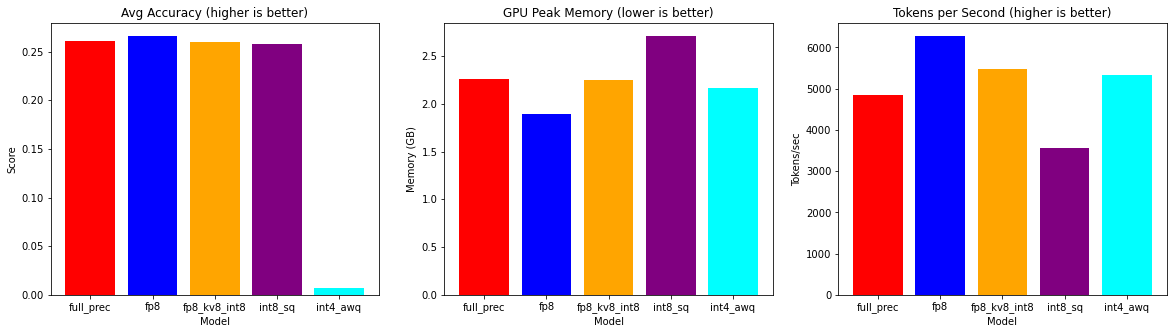

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

models = list(all_metrics.keys())  # Model names

# Extract metrics from all_metrics, replacing None with np.nan
avg_accuracies = [metrics[0] if metrics[0] is not None else np.nan for metrics in all_metrics.values()]
gpu_peak_mems = [metrics[1] if metrics[1] is not None else np.nan for metrics in all_metrics.values()]
tps = [metrics[2] if metrics[2] is not None else np.nan for metrics in all_metrics.values()]

plt.figure(figsize=(20, 5))

# Plotting Accuracies
plt.subplot(1, 3, 1)
plt.bar(models, avg_accuracies, color=['red', 'blue', 'orange', 'purple', 'cyan'])
plt.title('Avg Accuracy (higher is better)')
plt.ylabel('Score')
plt.xlabel('Model')

# Plotting GPU Peak Memory
plt.subplot(1, 3, 2)
plt.bar(models, gpu_peak_mems, color=['red', 'blue', 'orange', 'purple', 'cyan'])
plt.title('GPU Peak Memory (lower is better)')
plt.ylabel('Memory (GB)')
plt.xlabel('Model')

# Plotting Tokens per Second
plt.subplot(1, 3, 3)
plt.bar(models, tps, color=['red', 'blue', 'orange', 'purple', 'cyan'])
plt.title('Tokens per Second (higher is better)')
plt.ylabel('Tokens/sec')
plt.xlabel('Model')

## Latency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


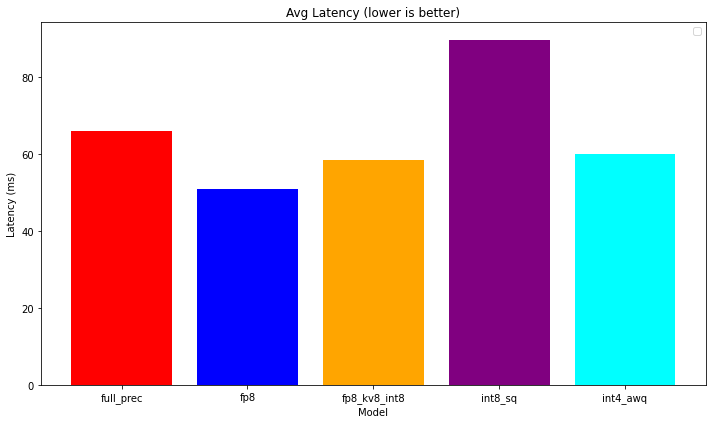

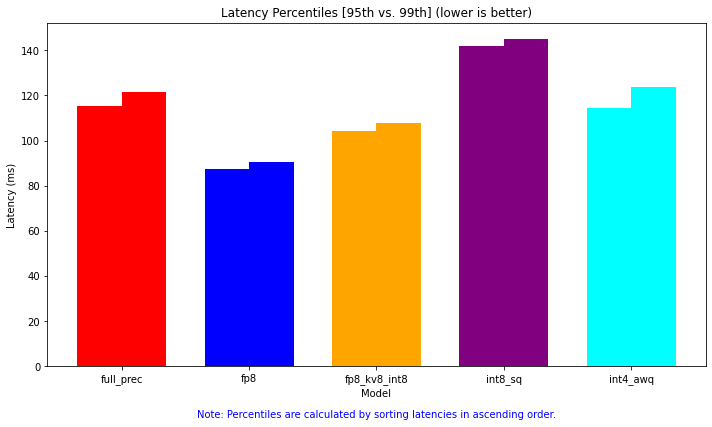

In [130]:
%matplotlib inline

n_models = len(models)
index = np.arange(n_models)  # Index for models
bar_width = 0.35 

# Extract metrics for plotting
latencies = [metrics[5] if metrics[5] is not None else np.nan for metrics in all_metrics.values()]
percentile95s = [metrics[3] if metrics[3] is not None else np.nan for metrics in all_metrics.values()]
percentile99s = [metrics[4] if metrics[4] is not None else np.nan for metrics in all_metrics.values()]

# Plot for Average Latency
colors = ['red', 'blue', 'orange', 'purple', 'cyan']
plt.figure(figsize=(10, 6))
plt.bar(models, latencies, color=colors)
plt.xlabel('Model')
plt.ylabel('Latency (ms)')
plt.title('Avg Latency (lower is better)')
plt.xticks(index, models, rotation='horizontal')
plt.legend()
plt.tight_layout()
plt.show()

# Plot for 95th and 99th Percentiles
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Adjust bar width for dual bar graph

# Plotting both 95th and 99th percentiles side by side
plt.bar(index - bar_width/2, percentile95s, bar_width, color=colors, label='95th Percentile')
plt.bar(index + bar_width/2, percentile99s, bar_width, color=colors, label='99th Percentile')

# Add a note about how percentiles are calculated
note = "Note: Percentiles are calculated by sorting latencies in ascending order."
plt.text(0.5, -0.15, note, transform=plt.gca().transAxes, fontsize=10, ha='center', color='blue')

plt.xlabel('Model')
plt.ylabel('Latency (ms)')
plt.title('Latency Percentiles [95th vs. 99th] (lower is better)')
plt.xticks(index, models, rotation='horizontal') 
plt.tight_layout()
plt.show()